In [126]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,Normalizer

train_data =  pd.read_csv("2023-declinometer_train.csv")

feature_column = "RoadSlope_100ms"
train_data['RoadSlope_100ms'] = train_data['RoadSlope_100ms'].round(4)



In [127]:
### slope ###
def calculate_points(actual_slope, predicted_slope):
    error = abs(predicted_slope - actual_slope)

    if 0.000 <= error < 0.001:
        return 1.00
    elif 0.001 <= error < 0.010:
        return 0.50
    elif 0.010 <= error < 0.020:
        return 0.25
    elif 0.020 <= error < 0.050:
        return 0.00
    elif 0.050 <= error < 0.300:
        return -0.25
    else:
        return -0.50

def calculate_slope_score(actual_slopes, predicted_slopes):
    total_points = 0

    for actual_slope, predicted_slope in zip(actual_slopes, predicted_slopes):
        points = calculate_points(actual_slope, predicted_slope)
        total_points += points

    # Calculate the average score
    score = total_points / len(actual_slopes)
    
    return score


### weight ###
def calculate_recall(actual_weights, predicted_weights, class_label):
    true_positives = sum((actual == class_label) and (predicted == class_label) for actual, predicted in zip(actual_weights, predicted_weights))
    false_negatives = sum((actual == class_label) and (predicted != class_label) for actual, predicted in zip(actual_weights, predicted_weights))
    
    recall = true_positives / (true_positives + false_negatives)
    return recall

def calculate_geometric_mean(recall_0, recall_1):
    return (recall_0 * recall_1) ** 0.5

def calculate_weight_score(actual_weights, predicted_weights, class_label_0 = 38, class_label_1 = 49):
    recall_0 = calculate_recall(actual_weights, predicted_weights, class_label_0)
    recall_1 = calculate_recall(actual_weights, predicted_weights, class_label_1)

    score = calculate_geometric_mean(recall_0, recall_1)
    return score


### slope + weight ###
def calculate_final_score(actual_slopes, predicted_slopes,actual_weights, predicted_weights):
    final_slope_score = calculate_slope_score(actual_slopes, predicted_slopes)
    final_weight_score = calculate_weight_score(actual_weights, predicted_weights)
    final_score= final_slope_score + final_weight_score
    return final_score

In [128]:
# 查看 RoadSlope_100ms 列中不同值的分布
slope_distribution = train_data['RoadSlope_100ms'].value_counts()

# 输出分布情况
print("Slope Distribution:")
print(slope_distribution)
len(slope_distribution)

Slope Distribution:
RoadSlope_100ms
 1.7000    1081
 0.6000     998
 1.5000     677
 0.4000     478
-2.7000     477
           ... 
-0.3791       1
 0.4284       1
-0.3203       1
 2.2680       1
 3.9726       1
Name: count, Length: 194, dtype: int64


194

In [129]:
first_100_rows = slope_distribution.head(45)
first_100_rows

RoadSlope_100ms
 1.7    1081
 0.6     998
 1.5     677
 0.4     478
-2.7     477
 4.2     461
 4.8     428
-0.2     338
 1.3     322
-1.9     312
-0.6     272
 2.1     272
-0.4     270
 2.3     261
 3.8     256
 0.2     238
-0.8     237
-1.0     235
 2.5     226
 2.7     219
 1.9     215
 1.0     214
 0.8     179
-3.1     174
-3.8     149
 0.0     148
 3.1     138
 2.9     129
-1.7     118
-4.0     108
 5.0      91
 3.4      88
 4.6      88
-1.3      78
 4.0      77
 3.6      73
-2.1      69
-2.5      54
-4.6      51
-1.5      48
-4.8      42
-2.9      30
-3.4      24
-2.3      14
-4.4      14
Name: count, dtype: int64

In [130]:
# 找到只出现< 1 次的数据的索引
unique_values = train_data[feature_column].value_counts() <=1
indices_to_remove = train_data[train_data[feature_column].isin(unique_values[unique_values].index)].index

# 删除数据
train_data_filtered = train_data.drop(index=indices_to_remove)

# 输出过滤后的数据集
len(train_data_filtered["RoadSlope_100ms"]) # 10551

# 查看 RoadSlope_100ms 列中不同值的分布
slope_distribution_filter = train_data_filtered['RoadSlope_100ms'].value_counts()

# 输出分布情况
print("Slope Distribution Filter:")
print(slope_distribution_filter)
len(slope_distribution_filter) # 40 class
slope_distribution_filter. tail(10)


Slope Distribution Filter:
RoadSlope_100ms
 1.7    1081
 0.6     998
 1.5     677
 0.4     478
-2.7     477
 4.2     461
 4.8     428
-0.2     338
 1.3     322
-1.9     312
 2.1     272
-0.6     272
-0.4     270
 2.3     261
 3.8     256
 0.2     238
-0.8     237
-1.0     235
 2.5     226
 2.7     219
 1.9     215
 1.0     214
 0.8     179
-3.1     174
-3.8     149
 0.0     148
 3.1     138
 2.9     129
-1.7     118
-4.0     108
 5.0      91
 3.4      88
 4.6      88
-1.3      78
 4.0      77
 3.6      73
-2.1      69
-2.5      54
-4.6      51
-1.5      48
-4.8      42
-2.9      30
-3.4      24
-4.4      14
-2.3      14
Name: count, dtype: int64


RoadSlope_100ms
 3.6    73
-2.1    69
-2.5    54
-4.6    51
-1.5    48
-4.8    42
-2.9    30
-3.4    24
-4.4    14
-2.3    14
Name: count, dtype: int64

In [131]:
len(train_data_filtered["RoadSlope_100ms"]) # 10347

10471

In [132]:
len(train_data['RoadSlope_100ms']) # 10620

10620

In [133]:
 # -3.1 -3.1    174
# 相对方差的前四项都小于百分之五
# 3.4  3.4     88
# 相对方差的前四项都小于百分之五
# -4.6 -4.6     51
# 相对方差的前四项都小于百分之五

#  273个待标定数据 --> 150个类别
aa = 10620 - 10347
print(aa)
bb = aa/10620
bb # 2.5%

cc = 10620 - 273 -174 -88 -51
print(cc)# 10034

273
10034


In [134]:
train_data_filtered_set = slope_distribution_filter.index.tolist()
train_data_filtered_set[-10:]

[3.6, -2.1, -2.5, -4.6, -1.5, -4.8, -2.9, -3.4, -4.4, -2.3]

In [135]:
import numpy as np
display(slope_distribution_filter.tail(20))
for mm in train_data_filtered_set:
    selected_rows = train_data[train_data['RoadSlope_100ms'] == mm]

    mean = selected_rows.mean(axis=0)
    std = selected_rows.std(axis=0)
    cv = (std / mean) * 100
    cv_no_nan = np.nan_to_num(cv, nan=0)
    cv_first_four = cv_no_nan[:4]
    # display(mean)
    # display(mm)
    # display(std.round(3))
    # if std['RngMod_trqCrSmin_100ms'] == 0 or std['ActMod_trqInr_100ms'] == 0:
    #     print(mm)
    #     print("Either 'RngMod_trqCrSmin_100ms' or 'ActMod_trqInr_100ms' has zero standard deviation.")
    # if std['RngMod_trqCrSmin_100ms'] == 0 and std['ActMod_trqInr_100ms'] == 0:
    #     print(mm)
    #     print("Both 'RngMod_trqCrSmin_100ms' and 'ActMod_trqInr_100ms' has zero standard deviation.")
    if all(abs(cv_first_four) < 5):
        print(mm)
        print("相对方差的前四项都小于百分之五")
        


#  5.0    91
#  3.4    88 
#  4.6    88
# -1.3    78
#  4.0    77
#  3.6    73
# -2.1    69
# -2.5    54
# -4.6    51 # signed
# -1.5    48

# -3.1
# Either 'RngMod_trqCrSmin_100ms' or 'ActMod_trqInr_100ms' has zero standard deviation.
# -3.8
# Either 'RngMod_trqCrSmin_100ms' or 'ActMod_trqInr_100ms' has zero standard deviation.
# -4.0
# Either 'RngMod_trqCrSmin_100ms' or 'ActMod_trqInr_100ms' has zero standard deviation.
# 3.4
# Either 'RngMod_trqCrSmin_100ms' or 'ActMod_trqInr_100ms' has zero standard deviation.
# -2.5
# Either 'RngMod_trqCrSmin_100ms' or 'ActMod_trqInr_100ms' has zero standard deviation.
# -4.6
# Either 'RngMod_trqCrSmin_100ms' or 'ActMod_trqInr_100ms' has zero standard deviation.

RoadSlope_100ms
 0.0    148
 3.1    138
 2.9    129
-1.7    118
-4.0    108
 5.0     91
 3.4     88
 4.6     88
-1.3     78
 4.0     77
 3.6     73
-2.1     69
-2.5     54
-4.6     51
-1.5     48
-4.8     42
-2.9     30
-3.4     24
-4.4     14
-2.3     14
Name: count, dtype: int64

-3.1
相对方差的前四项都小于百分之五
3.4
相对方差的前四项都小于百分之五
-4.6
相对方差的前四项都小于百分之五
-4.8
相对方差的前四项都小于百分之五
-2.9
相对方差的前四项都小于百分之五
-3.4
相对方差的前四项都小于百分之五
-4.4
相对方差的前四项都小于百分之五
-2.3
相对方差的前四项都小于百分之五


In [136]:
# -3.1
# 相对方差的前四项都小于百分之五
# 3.4
# 相对方差的前四项都小于百分之五
# -4.6
# 相对方差的前四项都小于百分之五
import pandas as pd
selected_rows = train_data[train_data['RoadSlope_100ms'] == -3.1]
selected_rows = train_data[train_data['RoadSlope_100ms'] == -4.6]
selected_rows = train_data[train_data['RoadSlope_100ms'] == 3.4]
display(selected_rows)




# 找到满足条件的行的索引
# values_to_drop = [-3.1, 3.4,-4.6]
values_to_drop = [99]

# 找到满足条件的行的索引
rows_to_drop = train_data_filtered[train_data_filtered['RoadSlope_100ms'].isin(values_to_drop)].index

# rows_to_drop = train_data_filtered[train_data_filtered['RoadSlope_100ms'] == -3.1].index
# rows_to_drop = train_data_filtered[train_data_filtered['RoadSlope_100ms'] == -4.6].index
# rows_to_drop = train_data_filtered[train_data_filtered['RoadSlope_100ms'] == 3.4].index


# 如果不想在原 DataFrame 上进行修改，可以创建一个新的 DataFrame
new_train_data_filtered = train_data_filtered.drop(rows_to_drop) # 10259 
display(new_train_data_filtered) 



,Epm_nEng_100ms,VehV_v_100ms,ActMod_trqInr_100ms,RngMod_trqCrSmin_100ms,CoVeh_trqAcs_100ms,Clth_st_100ms,CoEng_st_100ms,Com_rTSC1VRVCURtdrTq_100ms,Com_rTSC1VRRDTrqReq_100ms,RoadSlope_100ms,Vehicle_Mass
241,1174.5,61.24,2579.500,-168.0,9.999747,0,3,0,0,3.4,38.0
289,1171.5,61.05,2579.500,-168.0,9.999747,0,3,0,0,3.4,38.0
316,1174.0,61.25,2579.500,-168.0,9.999747,0,3,0,0,3.4,38.0
563,1209.5,62.72,2579.500,-168.0,9.999747,0,3,0,0,3.4,38.0
579,1210.5,62.68,2579.500,-168.0,9.999747,0,3,0,0,3.4,38.0
...,...,...,...,...,...,...,...,...,...,...,...
10446,1206.5,62.48,2579.500,-168.0,9.999747,0,3,0,0,3.4,38.0
10495,1178.5,61.44,2625.594,-168.0,9.999747,0,3,0,0,3.4,38.0
10508,1211.0,62.54,2579.500,-168.0,9.999747,0,3,0,0,3.4,38.0
10519,1187.0,61.73,2607.500,-168.0,9.999747,0,3,0,0,3.4,38.0


,Epm_nEng_100ms,VehV_v_100ms,ActMod_trqInr_100ms,RngMod_trqCrSmin_100ms,CoVeh_trqAcs_100ms,Clth_st_100ms,CoEng_st_100ms,Com_rTSC1VRVCURtdrTq_100ms,Com_rTSC1VRRDTrqReq_100ms,RoadSlope_100ms,Vehicle_Mass
0,1135.0,48.74,2632.000,-112.0,9.999747,0,3,0,0,3.8,49.0
1,1046.5,65.04,1682.001,-140.0,9.999747,0,3,0,0,1.5,49.0
2,914.5,68.22,1543.500,-140.0,9.999747,0,3,0,0,0.6,38.0
3,1169.5,72.24,1963.295,-168.0,9.999747,0,3,0,0,1.3,38.0
5,1099.0,47.51,2635.500,-112.0,9.999747,0,3,0,0,2.9,49.0
...,...,...,...,...,...,...,...,...,...,...,...
10615,908.5,67.70,1235.500,-140.0,9.999747,0,3,0,0,0.2,38.0
10616,1122.5,56.97,2604.000,-168.0,9.999747,0,3,0,0,0.0,38.0
10617,1386.5,49.29,2464.000,-140.0,9.999747,0,3,0,0,3.6,49.0
10618,1190.0,61.48,2579.500,-168.0,9.999747,0,3,0,0,2.9,38.0


In [137]:
# RoadSlope_100ms
#  1.9    217
#  1.0    214
#  0.8    180
# -3.1    174
# -3.8    149
#  0.0    148
#  3.1    138
#  2.9    129
# -1.7    118
# -4.0    108
#  5.0     91
#  4.6     88
#  3.4     88
# -1.3     78
#  4.0     78
#  3.6     73
# -2.1     69
# -2.5     54
# -4.6     51
# -1.5     48

# 选择某列中值为-2.3的所有行
#  3.6    73 # signed
# -2.1    69
# -2.5    54
# -4.6    51 # signed
# -1.5    48

selected_rows = train_data[train_data['RoadSlope_100ms'] == 3.4]
# selected_rows = train_data[train_data['RoadSlope_100ms'] == -4.6]
# selected_rows = train_data[train_data['RoadSlope_100ms'] == -3.1]

# Epm_nEng_100ms                1181.875000
# VehV_v_100ms                    87.604583
# ActMod_trqInr_100ms              0.000000
# RngMod_trqCrSmin_100ms        -168.000000
# CoVeh_trqAcs_100ms               9.999747

# Epm_nEng_100ms                8.282
# VehV_v_100ms                  0.758
# ActMod_trqInr_100ms           0.000
# RngMod_trqCrSmin_100ms        0.000


# selected_rows = train_data[train_data['RoadSlope_100ms'] == -3.8]

# Epm_nEng_100ms                966.764706
# VehV_v_100ms                   71.432745
# ActMod_trqInr_100ms             0.000000
# RngMod_trqCrSmin_100ms       -140.000000

# dtype: float64
# Epm_nEng_100ms                16.733
# VehV_v_100ms                   1.562
# ActMod_trqInr_100ms            0.000
# RngMod_trqCrSmin_100ms         0.000

# display(selected_rows.tail(100))

mean = selected_rows.mean(axis=0)
std = selected_rows.std(axis=0)
# 计算相对方差
cv = (std / mean) * 100
display(mean)
display(std.round(3))
cv_first_four = cv[:4]
display(cv_first_four)

Epm_nEng_100ms                1192.710227
VehV_v_100ms                    61.981477
ActMod_trqInr_100ms           2591.304932
RngMod_trqCrSmin_100ms        -168.000000
CoVeh_trqAcs_100ms               9.999747
Clth_st_100ms                    0.000000
CoEng_st_100ms                   3.000000
Com_rTSC1VRVCURtdrTq_100ms       0.000000
Com_rTSC1VRRDTrqReq_100ms        0.000000
RoadSlope_100ms                  3.400000
Vehicle_Mass                    38.000000
dtype: float64

Epm_nEng_100ms                15.448
VehV_v_100ms                   0.654
ActMod_trqInr_100ms           18.531
RngMod_trqCrSmin_100ms         0.000
CoVeh_trqAcs_100ms             0.000
Clth_st_100ms                  0.000
CoEng_st_100ms                 0.000
Com_rTSC1VRVCURtdrTq_100ms     0.000
Com_rTSC1VRRDTrqReq_100ms      0.000
RoadSlope_100ms                0.000
Vehicle_Mass                   0.000
dtype: float64

Epm_nEng_100ms            1.295174
VehV_v_100ms              1.054476
ActMod_trqInr_100ms       0.715106
RngMod_trqCrSmin_100ms   -0.000000
dtype: float64

In [138]:
cv_first_four[0]

1.2951739733707905

In [139]:
def df_std(train_X, test_X):
    mean = train_X.mean(axis=0)
    std = train_X.std(axis=0)
    train_X = ( train_X - mean ) / std
    test_X = ( test_X - mean ) / std

    return train_X, test_X

In [140]:
# -4.6
# 选择某列中值为-2.3的所有行 (这几个值都可以后处理)
# -4.8    42
# -2.9    30
# -3.4    24
# -4.4    14
# -2.3    14
selected_rows = train_data[train_data['RoadSlope_100ms'] == -4.8]
selected_rows = train_data[train_data['RoadSlope_100ms'] == -2.9]
selected_rows = train_data[train_data['RoadSlope_100ms'] == -3.4]
selected_rows = train_data[train_data['RoadSlope_100ms'] == -4.4]
selected_rows = train_data[train_data['RoadSlope_100ms'] == -2.3]

display(selected_rows)

,Epm_nEng_100ms,VehV_v_100ms,ActMod_trqInr_100ms,RngMod_trqCrSmin_100ms,CoVeh_trqAcs_100ms,Clth_st_100ms,CoEng_st_100ms,Com_rTSC1VRVCURtdrTq_100ms,Com_rTSC1VRRDTrqReq_100ms,RoadSlope_100ms,Vehicle_Mass
763,1260.0,77.62,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
1185,1261.0,77.71,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
1387,1262.0,77.75,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
2919,1263.5,77.83,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
4347,1263.5,77.97,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
5877,1268.0,78.00,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
6582,1264.5,77.95,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
7926,1257.0,77.59,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
8168,1261.5,77.86,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0
8321,1264.0,77.91,0.0,-196.0,9.999747,0,3,0,0,-2.3,38.0


In [141]:
slope_distribution.tail(30)

RoadSlope_100ms
-0.3506    1
-3.9423    1
-1.1848    1
-0.4724    1
 3.1257    1
 0.1082    1
 4.8563    1
 0.5409    1
-0.7275    1
 2.5110    1
-0.2871    1
 1.4008    1
 3.8439    1
-0.4261    1
 1.8980    1
-0.8414    1
 1.0384    1
-0.6858    1
 0.6682    1
 1.0183    1
 3.2443    1
-0.4150    1
-2.6964    1
 1.2695    1
 0.3692    1
-0.3791    1
 0.4284    1
-0.3203    1
 2.2680    1
 3.9726    1
Name: count, dtype: int64

In [142]:
# Specify the columns you want to include in the feature set
selected_columns = ['Epm_nEng_100ms', 'VehV_v_100ms', 'ActMod_trqInr_100ms', 'RngMod_trqCrSmin_100ms']

# Separate features and targets
X_train = new_train_data_filtered[selected_columns].values
y_train_slope = new_train_data_filtered['RoadSlope_100ms'].values
y_train_weight = new_train_data_filtered['Vehicle_Mass'].values

In [143]:
new_train_data_filtered['RngMod_trqCrSmin_100ms'].value_counts()
# -84.0 -0.8
# -308.0 1.7
# -252.0 1.7/1.3

RngMod_trqCrSmin_100ms
-168.0000    4348
-140.0000    3133
-196.0000    1532
-112.0000     984
-224.0000     141
             ... 
-123.2339       1
-171.6057       1
-186.5626       1
-176.5042       1
-173.2816       1
Name: count, Length: 272, dtype: int64

In [144]:
# 找到满足条件的行的索引
# values_to_drop = [4.2,4.8,-1.9]
values_to_drop = [4.2]

# 找到满足条件的行的索引
rows_to_drop = new_train_data_filtered[new_train_data_filtered['RoadSlope_100ms'].isin(values_to_drop)].index

# Create a DataFrame with the dropped rows
new_dropped_data = new_train_data_filtered.loc[rows_to_drop]

# Output the length of the dropped dataset
print("Length of dropped dataset:", len(new_dropped_data["RoadSlope_100ms"]))

# Save the dropped data to a CSV file
new_dropped_data.to_csv('new_dropped_data.csv', index=False)

Length of dropped dataset: 461


In [145]:
X_train

array([[1135.   ,   48.74 , 2632.   , -112.   ],
       [1046.5  ,   65.04 , 1682.001, -140.   ],
       [ 914.5  ,   68.22 , 1543.5  , -140.   ],
       ...,
       [1386.5  ,   49.29 , 2464.   , -140.   ],
       [1190.   ,   61.48 , 2579.5  , -168.   ],
       [ 914.5  ,   68.16 , 1683.5  , -140.   ]])

In [146]:
y_train_slope

array([3.8, 1.5, 0.6, ..., 3.6, 2.9, 0.6])

In [147]:
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

# values_to_drop = [-3.1, 3.4,-4.6]
n_classes = 45
# 给定的小数数组
decimals = np.array([-4.8,-4.6,-4., -4.4,-3.8,-3.4,-3.1,-2.9,-2.7, -2.5,-2.3, -2.1, -1.9, -1.7, -1.5, -1.3, -1., -0.8, -0.6, -0.4, -0.2,
                     0., 0.2, 0.4, 0.6, 0.8, 1., 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1,3.4,
                     3.6, 3.8, 4., 4.2, 4.6, 4.8, 5.])
# 映射到整数数组
mapped_integers = np.arange(len(decimals))

def get_origin(y_train_pred):
    original_decimals=[]
    for a in y_train_pred:
        original_decimals.append(decimals[a])
    y_train_slope_pred_new= np.array(original_decimals)
    return  y_train_slope_pred_new

def map_to_integers(decimal_values):
    # Create a mapping dictionary
    mapping_dict = {decimal: idx for idx, decimal in enumerate(decimals)}

    # Map decimal values to integers
    mapped_integers = np.array([mapping_dict[decimal] for decimal in decimal_values])

    return mapped_integers

def calculate_slope_score_with_class(actual_slopes_class, predicted_slopes_class):
    actual_slopes = get_origin(actual_slopes_class)
    predicted_slopes = get_origin(predicted_slopes_class)
    score = calculate_slope_score(actual_slopes, predicted_slopes)
    return score

# 从原始小数数组中获取对应的小数值
original_decimals = decimals[mapped_integers]

print("原始小数：", decimals)
print("映射到整数：", mapped_integers)
print("还原到小数：", original_decimals)

# discretizer = KBinsDiscretizer(n_bins=n_classes, encode='ordinal', strategy='kmeans')
y_train_classification = map_to_integers(y_train_slope)

# Split the data into train and validation sets
X_train_split, X_val_split, y_train_weight_split, y_val_weight_split, y_train_slope_split, y_val_slope_split = train_test_split(
    X_train, y_train_weight, y_train_classification, test_size=0.0001, random_state=101
)

原始小数： [-4.8 -4.6 -4.  -4.4 -3.8 -3.4 -3.1 -2.9 -2.7 -2.5 -2.3 -2.1 -1.9 -1.7
 -1.5 -1.3 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.3
  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.4  3.6  3.8  4.   4.2
  4.6  4.8  5. ]
映射到整数： [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
还原到小数： [-4.8 -4.6 -4.  -4.4 -3.8 -3.4 -3.1 -2.9 -2.7 -2.5 -2.3 -2.1 -1.9 -1.7
 -1.5 -1.3 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.3
  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.4  3.6  3.8  4.   4.2
  4.6  4.8  5. ]


In [148]:


# 使用 np.unique 得到唯一值和其对应的计数
unique_values, counts = np.unique(y_train_classification, return_counts=True)

# 输出结果
print("Unique Values:", unique_values)
print("Counts:", counts)
len(unique_values) # count 37

# 使用 np.unique 得到唯一值和其对应的计数
slope_unique_values, slope_counts = np.unique(y_train_slope, return_counts=True)

# 输出结果
print("slope_unique_values Values:", slope_unique_values)
print("slope_unique_values Counts:", slope_counts)
len(slope_unique_values) # count 37


Unique Values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Counts: [  42   51  108   14  149   24  174   30  477   54   14   69  312  118
   48   78  235  237  272  270  338  148  238  478  998  179  214  322
  677 1081  215  272  261  226  219  129  138   88   73  256   77  461
   88  428   91]
slope_unique_values Values: [-4.8 -4.6 -4.4 -4.  -3.8 -3.4 -3.1 -2.9 -2.7 -2.5 -2.3 -2.1 -1.9 -1.7
 -1.5 -1.3 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.3
  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.4  3.6  3.8  4.   4.2
  4.6  4.8  5. ]
slope_unique_values Counts: [  42   51   14  108  149   24  174   30  477   54   14   69  312  118
   48   78  235  237  272  270  338  148  238  478  998  179  214  322
  677 1081  215  272  261  226  219  129  138   88   73  256   77  461
   88  428   91]


45

In [149]:
# Create a DataFrame with the predictions
input_df = pd.DataFrame({
    'RoadSlope_classType': unique_values,
    'RoadSlope': slope_unique_values,
    'count':counts
})

# Sort the DataFrame based on the 'Salary' column
input_df = input_df.sort_values(by='count', ascending=False)

# Save the DataFrame to a CSV file
input_df.to_csv('slope_input.csv', index=False)
input_df

,RoadSlope_classType,RoadSlope,count
29,29,1.7,1081
24,24,0.6,998
28,28,1.5,677
23,23,0.4,478
8,8,-2.7,477
41,41,4.2,461
43,43,4.8,428
20,20,-0.2,338
27,27,1.3,322
12,12,-1.9,312


In [150]:
import pandas as pd
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from random import randint
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# 36	36	5.0	91
# 34	34	4.6	88
# 8	8	-1.3	78
# 32	32	4.0	77
# 30	30	3.6	73
# 4	4	-2.1	69
# 3	3	-2.5	54
# 7	7	-1.5	48

# classes_of_interest = [36,34,8,32,30,4,3,7]

# Assign higher weights to the classes of interest
# class_weights = {class_label: 10 if class_label in classes_of_interest else 1 for class_label in range(37)}

# Create a RandomForestClassifier with class weights


# clf1 = XGBClassifier(max_depth = 12,n_estimators = 500)v
clf1 = XGBClassifier()
clf2 = MLPClassifier()
# clf3 = RandomForestClassifier()
clf3 = RandomForestClassifier(random_state=42)
# 使用 class_weight 参数
# clf = RandomForestClassifier(class_weight='balanced')
clf4 = LogisticRegression(max_iter=1000)
clf5 = AdaBoostClassifier()
clf6 = LGBMClassifier()
clf = VotingClassifier(estimators=[('xgb', clf1),('mlp', clf2), ('rf', clf3), ('lg', clf4), ('adb', clf5),('lgbm', clf6)], voting='soft')
# clf = VotingClassifier(estimators=[('xgb', clf1),('mlp', clf2), ('rf', clf3), ('lg', clf4), ('adb', clf5)], voting='soft', weights=[2, 1, 1, 1, 2] )

# clf = clf.set_params(xgb='drop')
# clf = clf.set_params(rf='drop')

# xgb + rf = 0.7921026407573493
clf = clf.set_params(mlp='drop')
clf = clf.set_params(lg='drop')
clf = clf.set_params(adb='drop')
# clf = clf.set_params(lgbm='drop')




# 定义权重调整函数
def adjust_weights(X):
    # 将前两个特征的权重乘以2
    # X[:, :2] = X[:, :2] * 2
    # Add a new feature as the product of the first and second features
    X = np.c_[X, X[:, 0] * X[:, 1]]
    return X

# 创建 FunctionTransformer
weight_adjuster = FunctionTransformer(adjust_weights)


model = make_pipeline(StandardScaler(),weight_adjuster,clf)
# model = make_pipeline(StandardScaler(),clf)




model.fit(X_train_split, y_train_slope_split)

y_val_pred = model.predict(X_val_split)

# 评估模型性能
accuracy = accuracy_score(y_val_slope_split, y_val_pred)
print(f"Accuracy: {accuracy}")

val_slope_score = calculate_slope_score_with_class(y_val_slope_split,y_val_pred)
print(f"Val_slope_score: {val_slope_score}")




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 10469, number of used features: 5
[LightGBM] [Info] Start training from score -5.518504
[LightGBM] [Info] Start training from score -5.324348
[LightGBM] [Info] Start training from score -4.574043
[LightGBM] [Info] Start training from score -6.617116
[LightGBM] [Info] Start training from score -4.252227
[LightGBM] [Info] Start training from score -6.078120
[LightGBM] [Info] Start training from score -4.097118
[LightGBM] [Info] Start training from score -5.854976
[LightGBM] [Info] Start training from score -3.088657
[LightGBM] [Info] Start training from score -5.267190
[LightGBM] [Info] Start training from score -6.617116
[LightGBM] [Info] Start training from score -5.022067
[LightGBM] [Info] Start training from score -3.513171
[LightGBM]

In [151]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter

# Calculate the class distribution
class_distribution = dict(Counter(y_train_slope_split))

# # Determine the desired ratio for each class
# sampling_strategy = {cls: 2000 for cls in class_distribution.keys()}

# # Use ADASYN with the specified sampling_strategy
# oversample = ADASYN(sampling_strategy=sampling_strategy)

# 结合欠抽样
oversample = SMOTEENN()
oversample = SMOTE(sampling_strategy='auto')
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train_split, y_train_slope_split)
# Fit the model to the oversampled data
model.fit(X_train_oversampled, y_train_oversampled)
y_val_pred = model.predict(X_val_split)

# 评估模型性能
accuracy = accuracy_score(y_val_slope_split, y_val_pred)
print(f"Accuracy: {accuracy}")

val_slope_score = calculate_slope_score_with_class(y_val_slope_split,y_val_pred)
print(f"Val_slope_score: {val_slope_score}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 48645, number of used features: 5
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662
[LightGBM] [Info] Start training from score -3.806662


In [152]:
y_train_slope_split
# Assuming y_train_oversampled is a NumPy array
unique_values, counts = np.unique(y_train_slope_split, return_counts=True)

# Display the unique values and their corresponding counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 42
Value: 1, Count: 51
Value: 2, Count: 108
Value: 3, Count: 14
Value: 4, Count: 149
Value: 5, Count: 24
Value: 6, Count: 174
Value: 7, Count: 30
Value: 8, Count: 477
Value: 9, Count: 54
Value: 10, Count: 14
Value: 11, Count: 69
Value: 12, Count: 312
Value: 13, Count: 118
Value: 14, Count: 48
Value: 15, Count: 78
Value: 16, Count: 235
Value: 17, Count: 237
Value: 18, Count: 272
Value: 19, Count: 270
Value: 20, Count: 337
Value: 21, Count: 148
Value: 22, Count: 238
Value: 23, Count: 478
Value: 24, Count: 998
Value: 25, Count: 179
Value: 26, Count: 214
Value: 27, Count: 322
Value: 28, Count: 677
Value: 29, Count: 1081
Value: 30, Count: 215
Value: 31, Count: 272
Value: 32, Count: 261
Value: 33, Count: 226
Value: 34, Count: 219
Value: 35, Count: 129
Value: 36, Count: 138
Value: 37, Count: 88
Value: 38, Count: 73
Value: 39, Count: 256
Value: 40, Count: 77
Value: 41, Count: 461
Value: 42, Count: 88
Value: 43, Count: 427
Value: 44, Count: 91


In [153]:
y_train_oversampled
# Assuming y_train_oversampled is a NumPy array
unique_values, counts = np.unique(y_train_oversampled, return_counts=True)

# Display the unique values and their corresponding counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 1081
Value: 1, Count: 1081
Value: 2, Count: 1081
Value: 3, Count: 1081
Value: 4, Count: 1081
Value: 5, Count: 1081
Value: 6, Count: 1081
Value: 7, Count: 1081
Value: 8, Count: 1081
Value: 9, Count: 1081
Value: 10, Count: 1081
Value: 11, Count: 1081
Value: 12, Count: 1081
Value: 13, Count: 1081
Value: 14, Count: 1081
Value: 15, Count: 1081
Value: 16, Count: 1081
Value: 17, Count: 1081
Value: 18, Count: 1081
Value: 19, Count: 1081
Value: 20, Count: 1081
Value: 21, Count: 1081
Value: 22, Count: 1081
Value: 23, Count: 1081
Value: 24, Count: 1081
Value: 25, Count: 1081
Value: 26, Count: 1081
Value: 27, Count: 1081
Value: 28, Count: 1081
Value: 29, Count: 1081
Value: 30, Count: 1081
Value: 31, Count: 1081
Value: 32, Count: 1081
Value: 33, Count: 1081
Value: 34, Count: 1081
Value: 35, Count: 1081
Value: 36, Count: 1081
Value: 37, Count: 1081
Value: 38, Count: 1081
Value: 39, Count: 1081
Value: 40, Count: 1081
Value: 41, Count: 1081
Value: 42, Count: 1081
Value: 43, Count: 108

In [154]:

# Generate the classification report
y_train_pred = model.predict(X_train_split)
accuracy_train = accuracy_score(y_train_slope_split, y_train_pred)
print(f"Accuracy: {accuracy_train}")

train_slope_score = calculate_slope_score(y_train_slope_split,y_train_pred)
print(f"Train_slope_score: {train_slope_score}")

report =classification_report(y_train_slope_split, y_train_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Sort the DataFrame by F1-score in ascending order
report_df_sorted = report_df.sort_values(by='f1-score')

# Print the sorted classification report
print("Train Dataset Classification Report (Sorted by F1-score):")
print(report_df_sorted)

Accuracy: 0.9767886140032477
Train_slope_score: 0.9651829210048716
Train Dataset Classification Report (Sorted by F1-score):
              precision    recall  f1-score       support
10             0.538462  1.000000  0.700000     14.000000
7              0.714286  1.000000  0.833333     30.000000
11             0.809524  0.985507  0.888889     69.000000
1              0.809524  1.000000  0.894737     51.000000
40             0.819149  1.000000  0.900585     77.000000
9              0.868852  0.981481  0.921739     54.000000
41             0.964455  0.882863  0.921857    461.000000
13             0.872180  0.983051  0.924303    118.000000
8              0.997613  0.876310  0.933036    477.000000
6              0.921788  0.948276  0.934844    174.000000
43             0.932715  0.941452  0.937063    427.000000
12             0.959866  0.919872  0.939444    312.000000
0              0.893617  1.000000  0.943820     42.000000
42             0.916667  1.000000  0.956522     88.000000
macro

In [155]:
# report_df_sorted.tail(20)
report_df_sorted.head(20)

,precision,recall,f1-score,support
10,0.538462,1.000000,0.700000,14.000000
7,0.714286,1.000000,0.833333,30.000000
11,0.809524,0.985507,0.888889,69.000000
1,0.809524,1.000000,0.894737,51.000000
40,0.819149,1.000000,0.900585,77.000000
9,0.868852,0.981481,0.921739,54.000000
41,0.964455,0.882863,0.921857,461.000000
13,0.872180,0.983051,0.924303,118.000000
8,0.997613,0.876310,0.933036,477.000000
6,0.921788,0.948276,0.934844,174.000000


In [156]:
report_df_sorted.tail(30)

,precision,recall,f1-score,support
accuracy,0.976789,0.976789,0.976789,0.976789
weighted avg,0.978743,0.976789,0.977041,10469.000000
39,0.962264,0.996094,0.978887,256.000000
27,0.972727,0.996894,0.984663,322.000000
28,0.983847,0.989660,0.986745,677.000000
19,0.985240,0.988889,0.987061,270.000000
36,0.985612,0.992754,0.989170,138.000000
21,0.986577,0.993243,0.989899,148.000000
29,0.998126,0.985199,0.991620,1081.000000
34,0.986486,1.000000,0.993197,219.000000


In [157]:
# make predictions on the test set

test_data = pd.read_csv("2023-declinometer_test.csv")
X_test = test_data[selected_columns].values
# Separate features and targets


# Make predictions on the test dataset
y_test_slope_pred = model.predict(X_test)
y_test_slope_pred_proba = model.predict_proba(X_test)
y_test_slope_pred

array([21, 19, 43, ..., 25,  3, 29])

In [158]:
test_data_42 = pd.read_csv("new_dropped_data.csv")
X_test_42 = test_data_42[selected_columns].values
# Separate features and targets


# Make predictions on the test dataset
y_test_slope_pred_42 = model.predict(X_test_42)
y_pred_continuous_42 = get_origin(y_test_slope_pred_42)
y_pred_continuous_42

# Use numpy's unique function to get unique values and their counts
unique_values, counts = np.unique(y_pred_continuous_42, return_counts=True)

# Combine unique values and counts into a dictionary
result = dict(zip(unique_values, counts))

# Print the result
print(result)

# Add the predictions as a new column
test_data_42['42GT'] = y_pred_continuous_42

# Save the updated DataFrame to a new CSV file
test_data_42.to_csv("new_dropped_data_with_predictions.csv", index=False)

{2.9: 2, 3.1: 2, 3.8: 4, 4.0: 16, 4.2: 407, 4.6: 1, 4.8: 29}


In [159]:
# # Split the data into train and validation sets
# X_train = 
# y_train =
# X_train_split, X_val_split, y_train_weight_split, y_val_weight_split= train_test_split(
#     X_train, y_train_weight, y_train_classification, test_size=0.2, random_state=101)
# fit(X_train_split, np.where(y_train_weight_split == 38, 0, 1))

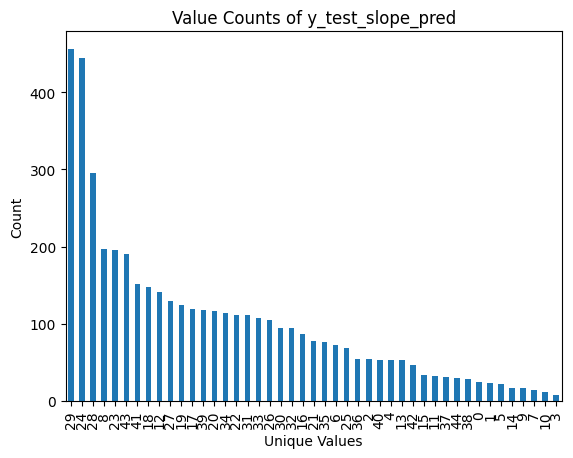

29    456
24    444
28    295
8     197
23    196
43    191
41    151
18    148
12    141
27    130
19    124
17    119
39    118
20    117
34    114
22    112
31    111
33    107
26    105
30     94
32     94
16     87
21     78
35     76
6      73
25     68
36     55
2      54
40     53
4      53
13     53
42     47
15     33
11     32
37     31
44     30
38     28
0      25
1      23
5      22
14     17
9      17
7      14
10     12
3       8
Name: count, dtype: int64


In [160]:
import pandas as pd
import numpy as np

# Assuming y_test_slope_pred is your predicted labels as a NumPy array
# Replace this with your actual variable name if it is different

# Convert to pandas Series if it's not already
y_test_slope_pred_series = pd.Series(y_test_slope_pred)

# Count occurrences of each unique value
value_counts = y_test_slope_pred_series.value_counts()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming value_counts is the result of y_test_slope_pred.value_counts()
# Replace this with your actual variable name if it is different

# Create a bar plot
value_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Value Counts of y_test_slope_pred')

# Show the plot
plt.show()


# Print the result
print(value_counts)

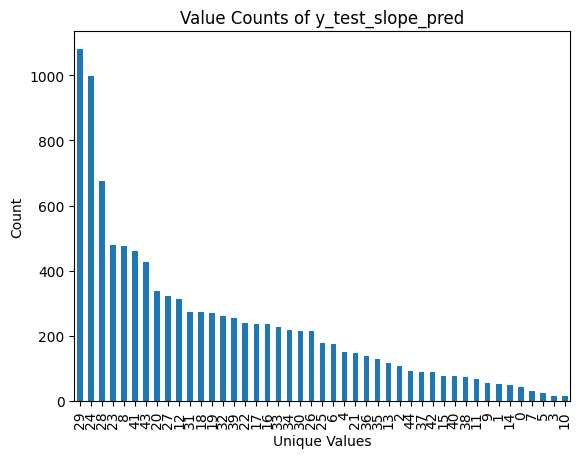

29    1081
24     998
28     677
23     478
8      477
41     461
43     428
20     338
27     322
12     312
31     272
18     272
19     270
32     261
39     256
22     238
17     237
16     235
33     226
34     219
30     215
26     214
25     179
6      174
4      149
21     148
36     138
35     129
13     118
2      108
44      91
37      88
42      88
15      78
40      77
38      73
11      69
9       54
1       51
14      48
0       42
7       30
5       24
3       14
10      14
Name: count, dtype: int64


In [161]:
import pandas as pd
import numpy as np

# Assuming y_test_slope_pred is your predicted labels as a NumPy array
# Replace this with your actual variable name if it is different

# Convert to pandas Series if it's not already
y_train_slope_series = pd.Series(y_train_classification)

# Count occurrences of each unique value
value_counts = y_train_slope_series.value_counts()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming value_counts is the result of y_test_slope_pred.value_counts()
# Replace this with your actual variable name if it is different

# Create a bar plot
value_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Value Counts of y_test_slope_pred')

# Show the plot
plt.show()


# Print the result
print(value_counts)

In [162]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, accuracy_score
import xgboost as xgb
import numpy as np
from eval import calculate_weight_score, calculate_slope_score, calculate_final_score

# Hyperparameter tuning using Grid Search for Weight Prediction
param_grid_weight = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200, 500],
}

model_weight = xgb.XGBClassifier(objective='binary:logistic', random_state=101)
grid_search_weight = GridSearchCV(model_weight, param_grid_weight, cv=3, scoring='accuracy')
# train weight


grid_search_weight.fit(X_train_split, np.where(y_train_weight_split == 38, 0, 1))
best_model_weight = grid_search_weight.best_estimator_

# Make predictions on the validation set for weight
y_test_weight_pred = best_model_weight.predict(X_test)

# Convert predictions to numpy arrays and apply the threshold for weight predictions
y_test_weight_pred = np.where(y_test_weight_pred == 0, 38.0, 49.0)

In [163]:
import pandas as pd
# 假设你的模型已经训练好，并且有了预测结果 y_val_pred
y_pred_continuous = get_origin(y_test_slope_pred)

# 输出还原后的预测结果
print("Restored Predictions:")

print(y_pred_continuous)


Restored Predictions:
[ 0.  -0.4  4.8 ...  0.8 -4.4  1.7]


In [164]:
y_pred_continuous

array([ 0. , -0.4,  4.8, ...,  0.8, -4.4,  1.7])

In [165]:
y_test_slope_pred

array([21, 19, 43, ..., 25,  3, 29])

In [166]:
import numpy as np

# Assuming y_test_slope_pred is your predicted array
# Replace the placeholders with your actual data
# 39,41,12
values_of_interest = range(45)
# Print the count for each specified value
aa = 0
for value in values_of_interest:
    count_value = np.count_nonzero(y_test_slope_pred == value)
    if count_value!=0:
        aa = aa+1
        print(f"The number of occurrences of the value {value} is: {count_value}")
print(aa)



The number of occurrences of the value 0 is: 25
The number of occurrences of the value 1 is: 23
The number of occurrences of the value 2 is: 54
The number of occurrences of the value 3 is: 8
The number of occurrences of the value 4 is: 53
The number of occurrences of the value 5 is: 22
The number of occurrences of the value 6 is: 73
The number of occurrences of the value 7 is: 14
The number of occurrences of the value 8 is: 197
The number of occurrences of the value 9 is: 17
The number of occurrences of the value 10 is: 12
The number of occurrences of the value 11 is: 32
The number of occurrences of the value 12 is: 141
The number of occurrences of the value 13 is: 53
The number of occurrences of the value 14 is: 17
The number of occurrences of the value 15 is: 33
The number of occurrences of the value 16 is: 87
The number of occurrences of the value 17 is: 119
The number of occurrences of the value 18 is: 148
The number of occurrences of the value 19 is: 124
The number of occurrences 

In [167]:
y_test_weight_pred

array([38., 38., 49., ..., 38., 49., 49.])

In [168]:
y_pred_continuous

array([ 0. , -0.4,  4.8, ...,  0.8, -4.4,  1.7])

In [169]:
# Create a DataFrame with the predictions
predictions_df = pd.DataFrame({
    'RoadSlope_100ms': y_pred_continuous,
    'Vehicle_Mass': y_test_weight_pred
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('xgboost_predictions_final.csv', index=False)

# Print or use predictions as needed
print("Test Set Predictions - Slope:", y_pred_continuous)
print("Test Set Predictions - Weight:", y_test_weight_pred)

Test Set Predictions - Slope: [ 0.  -0.4  4.8 ...  0.8 -4.4  1.7]
Test Set Predictions - Weight: [38. 38. 49. ... 38. 49. 49.]


In [170]:
# Create a DataFrame with the predictions
predictions_slope_df = pd.DataFrame({
    'RoadSlope_100ms': y_pred_continuous,
    'RoadSlope_classType': y_test_slope_pred
})

# Save the DataFrame to a CSV file
predictions_slope_df.to_csv('slope_final.csv', index=False)

In [171]:
X_test[1]

array([ 920.  ,   68.44, 1151.5 , -140.  ])